# Deferred Acceptance Model

James Yu, Vancouver School of Economics

The Deferred Acceptance algorithm, also known as the Gale-Shapely algorithm, is a method of finding a stable matching between two groups of individuals or entities. This notebook implements an interactive explanation of the workings of the algorithm, allowing you to step through the algorithm at your own pace.

In [1]:
import csv
import ipywidgets as widgets
import random
import time

random.seed(2)

from collections import defaultdict
from IPython.display import HTML, clear_output, display

In [2]:
import requests
r = requests.get("https://raw.githubusercontent.com/jbrightuniverse/VisualDeferredAcceptance/main/df_render.py")
with open("df_render.py", "wb") as f:
    f.write(r.content)

from df_render import * 
# imports custom rendering code for this notebook
# can be found at https://github.com/jbrightuniverse/VisualDeferredAcceptance/blob/main/df_render.py

A canonical setup involves a set of applicants and a set of institutions or acceptors. The example we will use in this notebook is that where the applicants are students, and the institutions are schools who need to assign students to their programs based on the applications they receive.

We'll jump right in to an example. Suppose we have six students and three programs/schools as follows **(program and school are interchangeable)**:


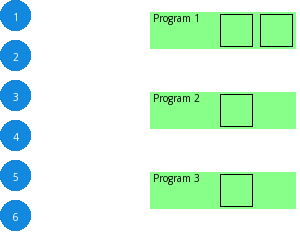

In [3]:
HTML(process(super_simple_example([2, 1, 1], 6, 3)))

The boxes inside each rectangle correspond to the number of spaces a school has.

What Deferred Acceptance does is it generates a "stable" assignment of students to programs. That is, given the schools that each student was assigned to, no changes to the assignment could make all the people involved better off at once. In order to make this assignment, we need an idea of what "better off" means. This is done by having preferences for each of the individuals involved. In this case, we need students to have preferred programs, and programs to have preferred students.

For example, Student 1 could have an application that looks like:

$$\text{Student 1: } \text{Program 1 } \succ \text{Program 2 } \succ \text{Program 3 }$$

On the form, this would be written as Program 1 being the first choice school, Program 2 being the second choice and Program 3 being the third choice. There is no constraint on the number of entries per application form, although more entries means more flexibility.

Students, or their parents **(here we use this interchangeably)**, would make these decisions based on the programs that they prefer. Programs however must also construct some sort of preference over students for the algorithm to work. These preferences can encapsulate particular priority-based guidelines that schools need to maintain, such as sibling priority, catchment priority, or district-locale priority (students from outside a particular school district).

As a very loose example, we could have students with properties such as:


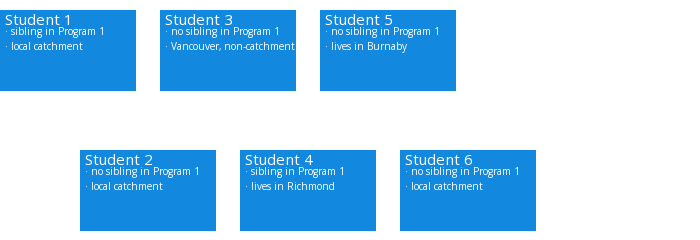

In [4]:
HTML(process(characteristic_example([["sibling in Program 1", "local catchment"], ["no sibling in Program 1", "local catchment"],
    ["no sibling in Program 1", "Vancouver, non-catchment"], ["sibling in Program 1", "lives in Richmond"],
    ["no sibling in Program 1", "lives in Burnaby"], ["no sibling in Program 1", "local catchment"]], 6)))

Now, since Program 1 prioritizes students with siblings over location guidelines, Student 1 and Student 4 would be grouped in the same preference pool. From there, we can apply the second guideline: **Student 1** is preferred to **Student 4** because Student 1 is in-catchment and Student 4 is not.

Since the other students have no siblings in Program 1, we look at catchment priority. Both Student 2 and Student 6 are in Program 1's catchment zone, so they are equally preferable. We can therefore randomly select one of the two students to prefer, say, **Student 2** over **Student 6**.

Student 3 is outside the catchment zone, but still in the same city as Program 1 (Vancouver), while Student 5 is outside of Vancouver. **Student 3** is therefore preferred to **Student 5**.

In the end, we have:

$$\text{Program 1: } \text{Student 1 } \succ \text{Student 4 } \succ \text{Student 2 } \succ \text{Student 6} \succ \text{Student 3} \succ \text{Student 5}$$

It takes a lot of work to do this manually so we can generate some data to run automatically. 

We can capture all the metrics we need through a simple set of CSV files, which are files you can export out of Microsoft Excel or any other spreadsheet software.

In [5]:
# in practice, create this in Microsoft Excel instead of here
student_application_form_file = """name,address,siblings,application
Student 1,catchment 1,"Student 7","Program 1,Program 2,Program 3"
Student 2,catchment 1,"Student 8","Program 2,Program 3,Program 1"
Student 3,catchment 2,"","Program 3, Program 1"
Student 4,catchment 3,"Student 9","Program 2,Program 1,Program 3"
Student 5,catchment 3,"","Program 1"
Student 6,catchment 1,"Student 10","Program 1,Program 2"
"""

with open("student_applications.csv", "w") as f:
    f.write(student_application_form_file)
    
# older_students is a general collection of students already enrolled in that school from a prior year
# guidelines is the conditions a school needs to hold (e.g. Sibling for sibling priority)
program_data_file = """name,address,capacity,older_students,guidelines
Program 1,catchment 1,2,"Student 7,Student 9","Sibling,Catchment"
Program 2,catchment 2,1,"Student 8,Student 10","Sibling,Catchment"
Program 3,catchment 1,1,"","Sibling,Catchment"
"""

with open("program_data.csv", "w") as f:
    f.write(program_data_file)

The above code is **not necessary** when you already have CSV files from spreadsheet software. The following code will read said spreadsheet files into variables:

In [6]:
student_application_forms = {}
with open("student_applications.csv") as f:
    reader = csv.DictReader(f, delimiter=',', quotechar='"')
    lines = [line for line in reader]
    for line in lines:
        content = {}
        content["form"] = [a.rstrip().lstrip() for a in line["application"].split(",") if a != ""]
        content["address"] = line["address"]
        content["siblings"] = [a.rstrip().lstrip() for a in line["siblings"].split(",") if a != ""]
        student_application_forms[line["name"]] = content

program_data = {}
with open("program_data.csv") as f:
    reader = csv.DictReader(f, delimiter=',', quotechar='"')
    lines = [line for line in reader]
    for line in lines:
        content = {}
        content["capacity"] = int(line["capacity"])
        content["address"] = line["address"]
        content["older_students"] = [a.rstrip().lstrip() for a in line["older_students"].split(",") if a != ""]
        content["guidelines"] = [a.rstrip().lstrip() for a in line["guidelines"].split(",") if a != ""]
        program_data[line["name"]] = content

It should be noted that the program allows different schools to require different guidelines/constraints (e.g. perhaps a school has a different catchment priority system).

Given the data, we process it into preference groups **(note we already have students' preferred schools from the application form)**. We will assume that each program in this district needs to maintain sibling priority and catchment priority. This means preferences will be different based on the location of the program.

In [7]:
constraints = {
    "Sibling": ["sibling", "no sibling"],
    "Catchment": ["local", "nonlocal", "outside"]
}

The above block of code has one entry for each guideline we need: siblings and location. Within them, we have a list of possible states that these guidelines could have; for example, one either has a sibling or doesn't have a sibling.

For catchment, we have in-catchment, in-district but out-of-catchment (nonlocal), or fully outside of district.

In [8]:
def has_sibling(student, program):
    """Checks if student has a sibling in program."""
    return "sibling" if len(set(student["siblings"]).intersection(program["older_students"])) else "no sibling"

def catchment(student, program):
    """Obtains the relative locale of student versus program."""
    # CHANGE THE NEXT LINE based on the name given to the out-of-district catchment
    name_of_out_of_district_catchment = "catchment 3" 
    
    if student["address"] == program["address"]: return "local" 
    elif student["address"] != name_of_out_of_district_catchment: return "nonlocal"
    else: return "outside"
    
functions = {"Sibling": has_sibling, "Catchment": catchment}

These two functions are critical to our code. Each one is a "logic generator" which provides the conditions for specifically why a student has a particular property. For example, for Sibling, this is true if there is at least one sibling of this student that is present in the program they are applying to.

For the catchment function, we either have the student sharing a catchment with the program, or they don't, and if they don't, they're either inside the district or outside the district.

In [9]:
all_ordered_groups = {}
for program in program_data:

    ordered_groups = [""]
    for guideline in program_data[program]["guidelines"]:
        new_copies = []
        for base in ordered_groups:
            for option in constraints[guideline]:
                new_copies.append(base + [",", ""][base == ""] + option)
        ordered_groups = new_copies
    
    all_ordered_groups[program] = ordered_groups

print(all_ordered_groups["Program 1"])

['sibling,local', 'sibling,nonlocal', 'sibling,outside', 'no sibling,local', 'no sibling,nonlocal', 'no sibling,outside']


The above list represents "priority groups" in terms of their preference by schools; observe those with "sibling" are ahead with those of "no sibling", and within those subgroups, order is based on locality to catchment.

Again, note we have a different set for each school based on the guidelines a school needs to maintain; in our example, all these sets are identical because each school is maintaining identical guidelines.

In [10]:
def generate_preferences(students, conditions):
    """Generates the preferences of a school over students."""
    priority_groups = defaultdict(list)
    for name in students:
        priority_groups[",".join([students[name][cond_name] for cond_name in conditions])].append(name) 
    return dict(priority_groups)

program_preferences = {}
priority_group_dict = {}

for program_name in program_data:
    # figure out what particular features students have in terms of the guidelines
    student_characteristics = {}
    program = program_data[program_name]
    for student_name in student_application_forms:
        student = student_application_forms[student_name]
        student_characteristics[student_name] = {guideline: functions[guideline](student, program) for guideline in program["guidelines"]}
    
    # use features to generate priority groups, randomize within said groups
    priority_groups = generate_preferences(student_characteristics, program["guidelines"])
    for priority_group in priority_groups:
        random.shuffle(priority_groups[priority_group])
        
    # save data for later
    priority_group_dict[program_name] = priority_groups
    ordered_students = []
    for group in all_ordered_groups[program_name]:
        if group in priority_groups:
            ordered_students += priority_groups[group]
    
    program_preferences[program_name] = ordered_students
    
program_preferences

{'Program 1': ['Student 1',
  'Student 4',
  'Student 6',
  'Student 2',
  'Student 3',
  'Student 5'],
 'Program 2': ['Student 6',
  'Student 2',
  'Student 3',
  'Student 1',
  'Student 5',
  'Student 4'],
 'Program 3': ['Student 6',
  'Student 1',
  'Student 2',
  'Student 3',
  'Student 4',
  'Student 5']}

The result is the following buckets of allocations based on relative priority/preference:

In [11]:
imgs = priority_group_example(all_ordered_groups, priority_group_dict, program_data)
tabs = [widgets.HTML(value = process(img)) for img in imgs]
tab = widgets.Tab()
tab.children = tabs
for i in range(len(tabs)):
    tab.set_title(index = i, title = list(program_data.keys())[i])
display(tab)

The algorithm itself works as follows. First, we initialize a bunch of empty schools.

Following this, schools will process all of the first choice applications of every student we have. This means for every application sent out by a student:

- If that school (the first choice of the student's application) has empty space left, internally accept the student being read.
- If that school has no space left, but the student being read is more preferable to someone currently in the school, internally accept the new student and remove + reject the less preferable one student.
- If that school has no space left, and the student is not preferred to anyone already in the school, do not accept them.

We can visually explore a single first-choice round to see this in practice:

In [12]:
state = localized_render_stage(form = student_application_forms, program_data = program_data, pref = program_preferences)
imgs, simgs, ranges, working_copy_of_students, schools, upbases, leftbases, is_matched = state
exec(LARGE_RENDER_PROCESS_ONE, globals(), locals())

Button(description='Previous Step', style=ButtonStyle())

Output()

Button(description='Replay Step', style=ButtonStyle())

Output()

Button(description='Next Step', style=ButtonStyle())

Output()

Label(value='Change Render Speed:')

FloatSlider(value=0.05, max=0.3, min=0.01, step=0.005)

Output()

(To see the result as a whole, view the first frame of the next animation below).

What happens here is we start with an iteration through all the students just once. Upon reaching each student, we assign it to a school if it has space.

If the school has no space, we have two cases as explained before. We check the preferences that the particular school has, and if the student we are looking at is more preferred than some student in the school, we remove the previous student (and remove that school from the student's preference list), and add our new student.

If instead the student is not preferable, we simply don't add it and we remove that school from the student's preference list.

In code, what we did above looks like the following:

In [13]:
my_schools = defaultdict(list)
my_working_copy_of_students = {name: {"form": student_application_forms[name]["form"].copy(), "accepted": False} for name in student_application_forms}

print("Initial System State:")
print("\n".join([name + ":" +  str(my_working_copy_of_students[name]) for name in my_working_copy_of_students]))

Initial System State:
Student 1:{'form': ['Program 1', 'Program 2', 'Program 3'], 'accepted': False}
Student 2:{'form': ['Program 2', 'Program 3', 'Program 1'], 'accepted': False}
Student 3:{'form': ['Program 3', 'Program 1'], 'accepted': False}
Student 4:{'form': ['Program 2', 'Program 1', 'Program 3'], 'accepted': False}
Student 5:{'form': ['Program 1'], 'accepted': False}
Student 6:{'form': ['Program 1', 'Program 2'], 'accepted': False}


In [14]:
def run_iteration():
    for student_name in my_working_copy_of_students:
        preferences = my_working_copy_of_students[student_name]["form"]
        if len(preferences) == 0 or my_working_copy_of_students[student_name]["accepted"] == True:
            # SPECIAL CASE: if the student does not have any program they can still apply to, skip them
            # SPECIAL CASE: if the student was already accepted, we do not need to process them here
            continue
            
        top_choice = preferences[0] # we apply the three cases given this student and their top choice
        if len(my_schools[top_choice]) < program_data[top_choice]["capacity"]:
            # if the number of students tentatively accepted at choice 1 is less than capacity, add this student
            my_schools[top_choice].append(student_name)
            my_working_copy_of_students[student_name]["accepted"] = True
        else:
            # otherwise, the school is full so check if the student is preferable
            school_preferred_students = program_preferences[top_choice]
            # sort students in decreasing preference order (increasing index)
            my_schools[top_choice].sort(key = lambda x: school_preferred_students.index(x)) 
            if school_preferred_students.index(student_name) < school_preferred_students.index(my_schools[top_choice][-1]):
                # if the applying student is "more preferred" than the least preferred student already tentatively accepted
                #    then accept this student and reject the other student
                other_name = my_schools[top_choice][-1]
                del my_schools[top_choice][-1]
                my_schools[top_choice].append(student_name)
                my_working_copy_of_students[student_name]["accepted"] = True
                my_working_copy_of_students[other_name]["accepted"] = False
                my_working_copy_of_students[other_name]["form"].remove(top_choice)
            else: # otherwise student is not preferable and permanently reject them from this program
                my_working_copy_of_students[student_name]["form"].remove(top_choice)

run_iteration()          
print("\n".join([name + ":" +  str(my_working_copy_of_students[name]) for name in my_working_copy_of_students]))
print()
print(dict(my_schools))

Student 1:{'form': ['Program 1', 'Program 2', 'Program 3'], 'accepted': True}
Student 2:{'form': ['Program 2', 'Program 3', 'Program 1'], 'accepted': True}
Student 3:{'form': ['Program 3', 'Program 1'], 'accepted': True}
Student 4:{'form': ['Program 1', 'Program 3'], 'accepted': False}
Student 5:{'form': [], 'accepted': False}
Student 6:{'form': ['Program 1', 'Program 2'], 'accepted': True}

{'Program 1': ['Student 1', 'Student 6'], 'Program 2': ['Student 2'], 'Program 3': ['Student 3']}


Like in the animation, we first assigned Student 1 to Program 1, Student 2 to Program 2, and Student 3 to Program 3.

We then at some point assigned Student 5 to Program 1, they were rejected in favour of Student 6. We can tell that this happened because the "form" entry of Student 5 no longer contains Program 1, meaning they were rejected.

It should be noted that when Student 5 was rejected, their form became empty. This shows the importance of multiple options - once a student is out of schools they could still apply to, they must be put on a waitlist for the schools they originally expressed interest in.

Student 4 was also rejected from Program 2, just as in the animation. We can now render another round:

In [15]:
state_catch = (working_copy_of_students, schools, upbases, leftbases, is_matched)
state = localized_render_stage(state = state_catch, program_data = program_data, pref = program_preferences)
imgs2, simgs2, ranges2, working_copy_of_students, schools, upbases, leftbases, is_matched = state
exec(LARGE_RENDER_PROCESS_TWO, globals(), locals())

Button(description='Previous Step', style=ButtonStyle())

Output()

Button(description='Replay Step', style=ButtonStyle())

Output()

Button(description='Next Step', style=ButtonStyle())

Output()

Label(value='Change Render Speed:')

FloatSlider(value=0.05, max=0.3, min=0.01, step=0.005)

Output()

(Again, to see the result as a whole, view the first frame of the next animation below).

Here in the animation we assign Student 4 to Program 1, since they expressed interest in Program 1 on their form, are currently not assigned to anything, and are actually more preferred in Program 1 than Student 6.

This means Student 6 needs to be assigned again, which turns out to be to Program 2 as they had it on their form and Program 2 prefers them to Student 2. In code, we see this in the following round:

In [16]:
run_iteration()          
print("\n".join([name + ":" +  str(my_working_copy_of_students[name]) for name in my_working_copy_of_students]))
print()
print(dict(my_schools))

Student 1:{'form': ['Program 1', 'Program 2', 'Program 3'], 'accepted': True}
Student 2:{'form': ['Program 3', 'Program 1'], 'accepted': False}
Student 3:{'form': ['Program 3', 'Program 1'], 'accepted': True}
Student 4:{'form': ['Program 1', 'Program 3'], 'accepted': True}
Student 5:{'form': [], 'accepted': False}
Student 6:{'form': ['Program 2'], 'accepted': True}

{'Program 1': ['Student 1', 'Student 4'], 'Program 2': ['Student 6'], 'Program 3': ['Student 3']}


Following this operation, Student 2 still has some entries on their form, so we can try to assign them again.

In [17]:
state_catch = (working_copy_of_students, schools, upbases, leftbases, is_matched)
state = localized_render_stage(state = state_catch, program_data = program_data, pref = program_preferences)
imgs3, simgs3, ranges3, working_copy_of_students, schools, upbases, leftbases, is_matched = state
exec(LARGE_RENDER_PROCESS_THREE, globals(), locals())

Button(description='Previous Step', style=ButtonStyle())

Output()

Button(description='Replay Step', style=ButtonStyle())

Output()

Button(description='Next Step', style=ButtonStyle())

Output()

Label(value='Change Render Speed:')

FloatSlider(value=0.05, max=0.3, min=0.01, step=0.005)

Output()

(The final allocation can be found in a frame below).

It turns out that Student 2's current top choice of Program 3 lets them into Program 3, as Program 3 prefers Student 2 to their existing Student 3. We thus remove Student 3, which leads to a requirement of assigning Student 3 somewhere now since they do have one choice on their form left.

However, because Program 1 doesn't prefer Student 3 to anyone, they are rejected, leaving their form empty. In code, this looks like:

In [18]:
run_iteration()          
print("\n".join([name + ":" +  str(my_working_copy_of_students[name]) for name in my_working_copy_of_students]))
print()
print(dict(my_schools))

Student 1:{'form': ['Program 1', 'Program 2', 'Program 3'], 'accepted': True}
Student 2:{'form': ['Program 3', 'Program 1'], 'accepted': True}
Student 3:{'form': [], 'accepted': False}
Student 4:{'form': ['Program 1', 'Program 3'], 'accepted': True}
Student 5:{'form': [], 'accepted': False}
Student 6:{'form': ['Program 2'], 'accepted': True}

{'Program 1': ['Student 1', 'Student 4'], 'Program 2': ['Student 6'], 'Program 3': ['Student 2']}


Every student that is not currently accepted (that is, 'accepted' is False) has an empty form. This means there are no more possible applications that could be made, and thus the algorithm is complete. The allocation looks like that of the following frame:


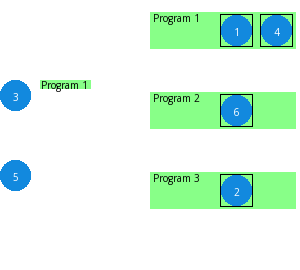

In [19]:
HTML(process(imgs3[-20]))

Recall the original preferences of the programs was:

In [20]:
program_preferences

{'Program 1': ['Student 1',
  'Student 4',
  'Student 6',
  'Student 2',
  'Student 3',
  'Student 5'],
 'Program 2': ['Student 6',
  'Student 2',
  'Student 3',
  'Student 1',
  'Student 5',
  'Student 4'],
 'Program 3': ['Student 6',
  'Student 1',
  'Student 2',
  'Student 3',
  'Student 4',
  'Student 5']}

Program 1 ended up with their top two preferred students, Program 2 ended up with their preferred student, and Program 3 received their second-most-preferred student as Program 2 still has Student 6.

Recall that the preferences of the students was:

In [21]:
{name: student_application_forms[name]["form"] for name in student_application_forms}

{'Student 1': ['Program 1', 'Program 2', 'Program 3'],
 'Student 2': ['Program 2', 'Program 3', 'Program 1'],
 'Student 3': ['Program 3', 'Program 1'],
 'Student 4': ['Program 2', 'Program 1', 'Program 3'],
 'Student 5': ['Program 1'],
 'Student 6': ['Program 1', 'Program 2']}

Student 1 got into their most preferred program, and Student 6 had to settle for Program 2. This meant Student 2 had to settle for Program 3, and Student 4 had to settle for Program 1. All other students, being less preferable by the schools themselves, did not receive spots due to lack of capacity, and most notably, these were two students with no sibling priority that tended to reside outside of the catchments of most of the programs that they specifically were applying to, whereas the other students had higher priority. 

The key engine of the algorithm is that it doesn't stop once all schools are full; rather, it keeps going until all applications are read, as until that is conducted, not all allocations may be stable. This is the "deferred" part of Deferred Acceptance.

The entirety of the algorithm can be found rendered in this GIF file. Note it may not be at the beginning when you see it, but if you download it, it will start from the beginning. Otherwise you can wait for it to loop.


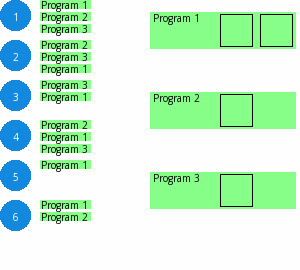

In [22]:
HTML(process(simgs + simgs2 + simgs3, 100))

## Important Extension: Students Dropping Out

It is important to consider all factors when using the Deferred Acceptance algorithm, and one of those is student-directed rejections. This is when a student or parent receive a final acceptance offer, but then turn it down in favour of some externality such as switching districts, private schools, etc.

Deferred Acceptance is capable of handling this with minimal changes, and this variant is partly explained in [https://montoya.econ.ubc.ca/Econ306/deferred_acceptance.pdf](https://montoya.econ.ubc.ca/Econ306/deferred_acceptance.pdf). I have slightly modified it to run the original algorithm to completion first (that is, the algorithm is being run with all seats at all times), but the point at which this operation can be inserted can easily be changed. (The issue with the method in the notes is students are locked out of slots taken by first-choice applicants, which acts against school preferences and the preferences of the remaining students so here we conduct the post-dropout operations only after we do a full run of the initial algorithm).

The key part of this change is the following: if a student explicitly rejects an offer from, say, Program X, find *all* students (both assigned and unassigned) that prefer Program X to their current assignment (which could be no assignment).

One of these students, say Student Y, will be most preferred by Program X (as they have their own preferences). Let Program X give out an offer of acceptance to Student Y with a **deadline** (to account for the fact that they may previously have been placed in some less-preferred program).

If Student Y rejects this offer, this is a change in preferences. Remove Program X from Student Y's preferences (from the form) and repeat with the next-most-preferred student (by Program X), say, Student Y2.

If everyone rejects the offer, leave the slot open. However, if someone *accepts* the offer, say Student Z, assign Student Z to Program X and remove them from the original program they were in, say Program W. (If they were not previously assigned, there is no program to remove from). Here we leave Student Z in Program W's preferences since they were not rejected by Program W.

Finally, this means Program W has a new open slot, so we repeat the above process with this new slot. We do that until there are no more empty slots.

As an example, lets say we ran the algorithm once on the data we had above, but now Student 1 decides to drop out:

In [23]:
my_working_copy_of_students

{'Student 1': {'form': ['Program 1', 'Program 2', 'Program 3'],
  'accepted': True},
 'Student 2': {'form': ['Program 3', 'Program 1'], 'accepted': True},
 'Student 3': {'form': [], 'accepted': False},
 'Student 4': {'form': ['Program 1', 'Program 3'], 'accepted': True},
 'Student 5': {'form': [], 'accepted': False},
 'Student 6': {'form': ['Program 2'], 'accepted': True}}

In [24]:
quitting_student = "Student 1"
program_to_fill = my_working_copy_of_students["Student 1"]["form"][0]
del my_working_copy_of_students[quitting_student] # this is the student that quit
my_working_copy_of_students

{'Student 2': {'form': ['Program 3', 'Program 1'], 'accepted': True},
 'Student 3': {'form': [], 'accepted': False},
 'Student 4': {'form': ['Program 1', 'Program 3'], 'accepted': True},
 'Student 5': {'form': [], 'accepted': False},
 'Student 6': {'form': ['Program 2'], 'accepted': True}}

In [25]:
my_schools

defaultdict(list,
            {'Program 1': ['Student 1', 'Student 4'],
             'Program 2': ['Student 6'],
             'Program 3': ['Student 2']})

In [26]:
my_schools[program_to_fill].remove(quitting_student)

As you can see, Student 1 was previously assigned to Program 1. This means we need to figure out who to make an offer to for this new slot. 

Because we expect this to happen after offers are sent out, we cannot just ask everyone to re-apply again, so we must make a school-side offer. We do this by finding all students with more interest in Program 1 than their existing program.

It should be noted that a student that was previously fully rejected from Program 1 due to the student that quit may now be able to get into Program 1 despite said previous rejection. This requires us to pull back the original application forms:

In [27]:
current_allocations = {}
for student in my_working_copy_of_students:
    if len(my_working_copy_of_students[student]["form"]):
        current_allocations[student] = my_working_copy_of_students[student]["form"][0]
    else:
        current_allocations[student] = None

current_allocations

{'Student 2': 'Program 3',
 'Student 3': None,
 'Student 4': 'Program 1',
 'Student 5': None,
 'Student 6': 'Program 2'}

In [28]:
interested = []

for student in current_allocations:
    if current_allocations[student] != None:
        form = student_application_forms[student]["form"]
        ind = form.index(current_allocations[student])
    else:
        ind = len(program_data) # if they are not in a school, their current preference index is infinity
    if form.index(program_to_fill) < ind:
        interested.append(student)

interested

['Student 3', 'Student 5', 'Student 6']

Here we have three students that might want to take this new slot, so we get Program 1 to pick the one they most prefer:

In [29]:
prefs = program_preferences[program_to_fill]
prefs

['Student 1', 'Student 4', 'Student 6', 'Student 2', 'Student 3', 'Student 5']

In [30]:
indices = [prefs.index(s) for s in interested]
indices

[4, 5, 2]

In [31]:
new = interested[indices.index(min(indices))]
new

'Student 6'

Program 1 is most interested in Student 6. Thus, we make an offer to Student 6 and give them maybe a few days to accept it. We will determine whether this acceptance happens at random.

In [32]:
accept = random.randrange(2)
accept

1

Let's say 0 is no and 1 is yes. Here we have a 1, so we assign Student 6 to Program 1 and remove Student 6 from their existing program. This opens up another slot, and we repeat until we run out of slots.

In [33]:
my_schools[program_to_fill].append(new)
if current_allocations[new] != None:
    old = current_allocations[new]
    current_allocations[new] = program_to_fill
    my_schools[current_allocations[new]].remove(new)
    program_to_fill = old
else:
    current_allocations[new] = program_to_fill
    program_to_fill = None
    
my_working_copy_of_students[new]["accepted"] = True
current_allocations

{'Student 2': 'Program 3',
 'Student 3': None,
 'Student 4': 'Program 1',
 'Student 5': None,
 'Student 6': 'Program 1'}

In [34]:
# general procedure for handling explicit rejections (contains all the above code with extra loops)
# uncomment the following code if deploying in practice
# must use the same variables as a completed Deferred Acceptance round

"""
quitting_student = "Student 1"
program_to_fill = my_working_copy_of_students["Student 1"]["form"][0]
del my_working_copy_of_students[quitting_student] # this is the student that quit
my_schools[program_to_fill].remove(quitting_student)
current_allocations = {}
for student in my_working_copy_of_students:
    if len(my_working_copy_of_students[student]["form"]):
        current_allocations[student] = my_working_copy_of_students[student]["form"][0]
    else:
        current_allocations[student] = None
"""

while True:
    interested = []
    for student in current_allocations:
        if current_allocations[student] != None:
            form = student_application_forms[student]["form"]
            ind = form.index(current_allocations[student])
        else:
            ind = len(program_data)
        if form.index(program_to_fill) < ind:
            interested.append(student)
    display(interested)
    print(" above: interested students for", program_to_fill)
    if len(interested) == 0:
        # if nobody is interested in this slot, the algorithm stops as we have reached stability
        break
    
    new = None
    while len(interested) != 0:
        prefs = program_preferences[program_to_fill]
        indices = [prefs.index(s) for s in interested]
        new = interested[indices.index(min(indices))]
        accept = random.randrange(2) # **NOTE**: in reality, you would pause the algorithm here until you received a reply
        if accept == 0:
            print(new, "REJECTED OFFER FROM", program_to_fill)
            # CASE: if the person decides not to accept this offer, we turn to the next person
            interested.remove(new)
            if len(interested) == 0:
                # CASE: somehow everyone rejected this offer, so we are done
                break
        else:
            print(new, "ACCEPTED OFFER FROM", program_to_fill)
            # CASE: accepted offer, continue
            break
    
    if len(interested) == 0: break # if the loop had everyone reject, break
        
    my_schools[program_to_fill].append(new)
    if current_allocations[new] != None:
        old = current_allocations[new]
        current_allocations[new] = program_to_fill
        my_schools[current_allocations[new]].remove(new)
        program_to_fill = old
    else:
        current_allocations[new] = program_to_fill
        program_to_fill = None

    
    my_working_copy_of_students[new]["accepted"] = True
        
        
    display(current_allocations)
    print(" above: current allocations")
    if not program_to_fill: break # if the student we just accepted was not previously accepted, we are done

['Student 2', 'Student 3', 'Student 4', 'Student 5']

 above: interested students for Program 2
Student 2 REJECTED OFFER FROM Program 2
Student 3 REJECTED OFFER FROM Program 2
Student 5 REJECTED OFFER FROM Program 2
Student 4 ACCEPTED OFFER FROM Program 2


{'Student 2': 'Program 3',
 'Student 3': None,
 'Student 4': 'Program 2',
 'Student 5': None,
 'Student 6': 'Program 1'}

 above: current allocations


['Student 3', 'Student 5']

 above: interested students for Program 1
Student 3 ACCEPTED OFFER FROM Program 1


{'Student 2': 'Program 3',
 'Student 3': 'Program 1',
 'Student 4': 'Program 2',
 'Student 5': None,
 'Student 6': 'Program 1'}

 above: current allocations


In the end, Student 6 took Student 1's spot, Student 4 took Student 6's old spot, Student 3 took Student 4's old spot, and Student 2 took Student 3's old spot, which was a new allocation (since Student 3 was not previously in a school), terminating the new algorithm. We can re-run this every time we need to deal with another rejection.

Essentially what this does is it extends the algorithm: we continue to use the top preferences of each student and the top preferences of each program to determine the allocation, but this time we don't reject anyone ourselves because everyone else was already optimally accepted anyway.

## Small Extension: Late Entries

If a student has an application that comes in during the middle of the school year, they can simply be added to the pool of unmatched students waiting for a slot to open up from someone dropping out under the previous example. This requires two things: one is simply adding them to the list of students with their application form, and the other is computing the schools' preference for this student by re-running the preference-generating code from earlier in this notebook. From there, it is only a matter of running the previously shown "explicit rejection" code when a seat opens up, which will automatically take into account this new entry in the waitlists.

## Works Cited/Consulted

Peters, M. *Deferred Acceptance*. Personal collection of M. Peters, University of British Columbia, Vancouver, BC. 


    Retrieved from https://montoya.econ.ubc.ca/Econ306/deferred_acceptance.pdf, 6 May 2021.